In [29]:
import random
import os
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from tensorflow.python.keras.models import Model

from code.nn_model.models import transformers
from code.read_data import get_data
from code.read_data import read_fnol_data

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, precision_score, recall_score, classification_report, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import warnings
from joblib import dump, load


warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

seed = 10
# # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [30]:
cv_inner = StratifiedKFold(n_splits=5)

reg_RF = RandomForestClassifier(random_state=2022)
reg_lin = LogisticRegression()
reg_DT = DecisionTreeClassifier(random_state=2022, )
reg_MLP = MLPClassifier(random_state=2022)
reg_KN = KNeighborsClassifier()
reg_SVC = SVC(random_state=2022, probability=True, )
reg_adboost = AdaBoostClassifier(random_state=2022)

space_rf = dict()
space_rf['n_estimators'] = [i for i in range(1, 30)]
space_rf['max_features'] = [i for i in range(1, 30)]
space_rf['max_depth'] = [i for i in range(2, 30)]
space_rf['criterion'] = ["gini", "entropy"]

space_lr = dict()
space_lr['C'] = np.linspace(0.0001, 10, 200)
space_lr['max_iter'] = np.linspace(0, 200, 200)
space_lr['solver'] = ['newton-cg', 'lbfgs', 'sag', 'saga']

space_dt = dict()
space_dt['max_features'] = ["auto", "sqrt", "log2"]
space_dt['max_depth'] = [i for i in range(2, 20)]
space_dt['criterion'] = ["gini", "entropy"]

space_mlp = dict()
space_mlp['solver'] = ['lbfgs', 'sgd', 'adam']
space_mlp['hidden_layer_sizes'] = [i for i in range(2, 250)]
space_mlp['max_iter'] = [i for i in range(2, 150)]

space_kn = dict()
space_kn['n_neighbors'] = [i for i in range(2, 20)]
space_kn['weights'] = ['uniform', 'distance']
space_kn['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

space_svc = dict()
space_svc['C'] = np.linspace(0.0001, 10, 200)
space_svc['kernel'] = ['poly', 'rbf']

space_adboost = dict()
space_adboost['learning_rate'] = np.linspace(0.001, 1, 20)
space_adboost['n_estimators'] = [i for i in range(1, 30)]


In [31]:
def prepare_data_with_nn_output(df):
    layers_output = []

    test_img, test_text, test_label = get_data(df)
    weight_path = "../nn_model/outputs/xray_class_weights.best.hdf5"

    model = transformers()
    model.load_weights(weight_path)

    layer_outputs = [layer.output for layer in model.layers[115:121]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    for i in range(0, test_img.shape[0]):
        activations = activation_model.predict(tf.expand_dims(test_img[i], axis=0))
        layers_output.append(activations[2][0])

    concat = np.concatenate((test_text, layers_output), axis=1)
    return np.array(concat), test_label

In [32]:
def addToResults(report_df, test_x, test_y, y_pred_lr, name, model, params_best):
    report = pd.DataFrame(columns={'Accuracy'}, data=[0])
    report['F1'] = f1_score(test_y, y_pred_lr, )
    report['Precision'] = precision_score(test_y, y_pred_lr, )
    report['Recall'] = recall_score(test_y, y_pred_lr, )
    report['Accuracy'] = model.score(test_x, test_y)
    report['Balanced Acc'] = balanced_accuracy_score(test_y, y_pred_lr)
    report['ROC-AUC'] = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1], average="weighted")
    report['params'] = params_best

    report.index = [name]
    report_df = report_df.append(report)

    return report_df

In [33]:
def xval_test(model, space, df_report, train_x, train_y, test_x, test_y):
    acc_best = 0
    params_best = dict()
    num_iteration = 300
    cv_inner = StratifiedKFold(n_splits=5)

    for i in range(0, num_iteration):
        search = RandomizedSearchCV(model, space, scoring='accuracy', cv=cv_inner)
        result = search.fit(train_x, train_y)
        best_model = result.best_estimator_
        yhat_temp = best_model.predict(test_x)
        acc = accuracy_score(test_y, yhat_temp)
        if (acc_best < acc):
            best_model_save = best_model
            params_best = result.best_params_
            acc_best = acc
            yhat = yhat_temp
            dump(result, f'{type(best_model_save).__name__}.joblib')

    print(type(best_model_save).__name__)
    print('>acc=%.3f, cfg=%s' % (acc_best, params_best))
    print('Accuracy: %.3f ' % (acc_best))

    cm = confusion_matrix(test_y, yhat)

    # Plot confusion matrix
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = '{0}. Accuracy Score: {1}'.format(type(best_model_save).__name__, acc_best)
    plt.title(all_sample_title, size=15)

    plt.show()
    df_report = addToResults(df_report, test_x,
                             test_y, yhat, type(best_model_save).__name__, best_model_save, str(params_best))

    return df_report

In [34]:
train_df, test_df = read_fnol_data()

concat_train, train_y = prepare_data_with_nn_output(train_df)
concat_test, test_y = prepare_data_with_nn_output(test_df)

RandomForestClassifier
>acc=0.745, cfg={'n_estimators': 5, 'max_features': 21, 'max_depth': 6, 'criterion': 'gini'}
Accuracy: 0.745 


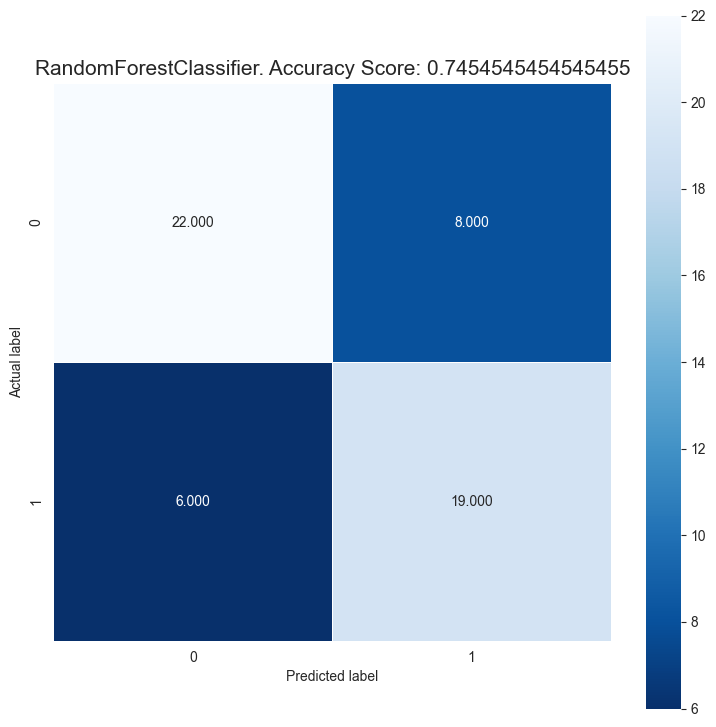

LogisticRegression
>acc=0.618, cfg={'solver': 'lbfgs', 'max_iter': 54.27135678391959, 'C': 1.0051150753768845}
Accuracy: 0.618 


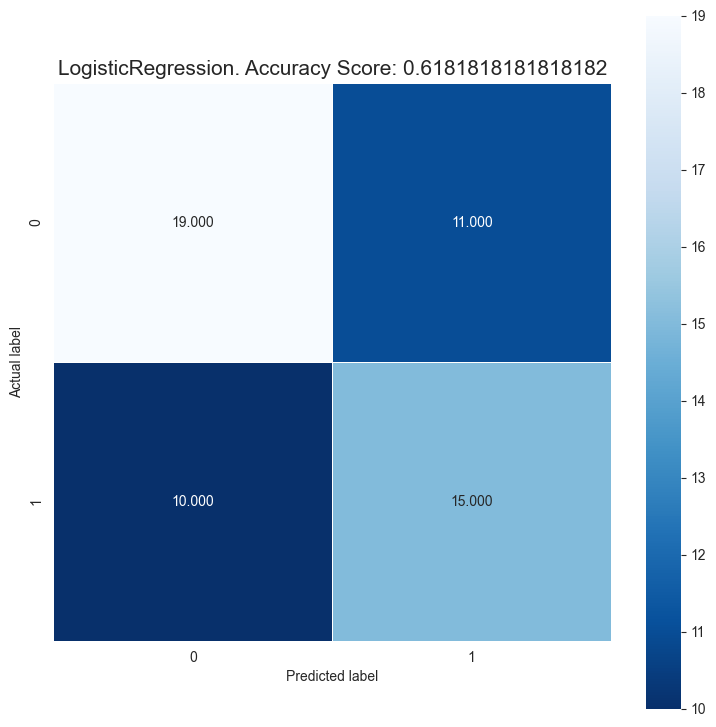

DecisionTreeClassifier
>acc=0.673, cfg={'max_features': 'log2', 'max_depth': 13, 'criterion': 'entropy'}
Accuracy: 0.673 


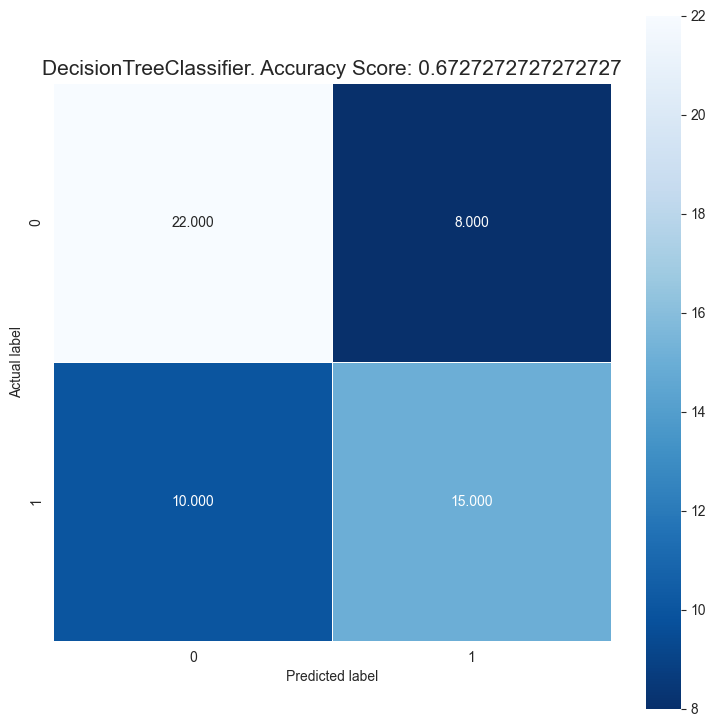

MLPClassifier
>acc=0.764, cfg={'solver': 'adam', 'max_iter': 114, 'hidden_layer_sizes': 123}
Accuracy: 0.764 


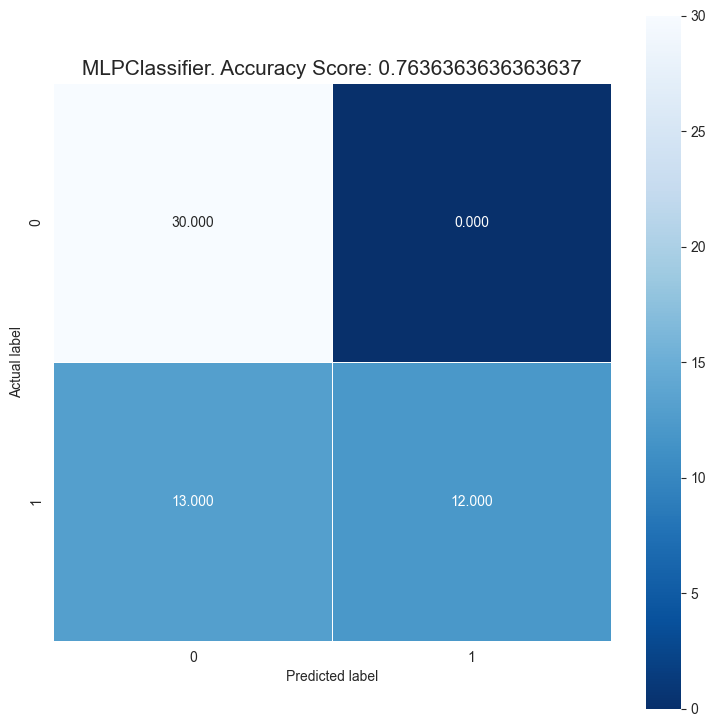

KNeighborsClassifier
>acc=0.691, cfg={'weights': 'distance', 'n_neighbors': 14, 'algorithm': 'ball_tree'}
Accuracy: 0.691 


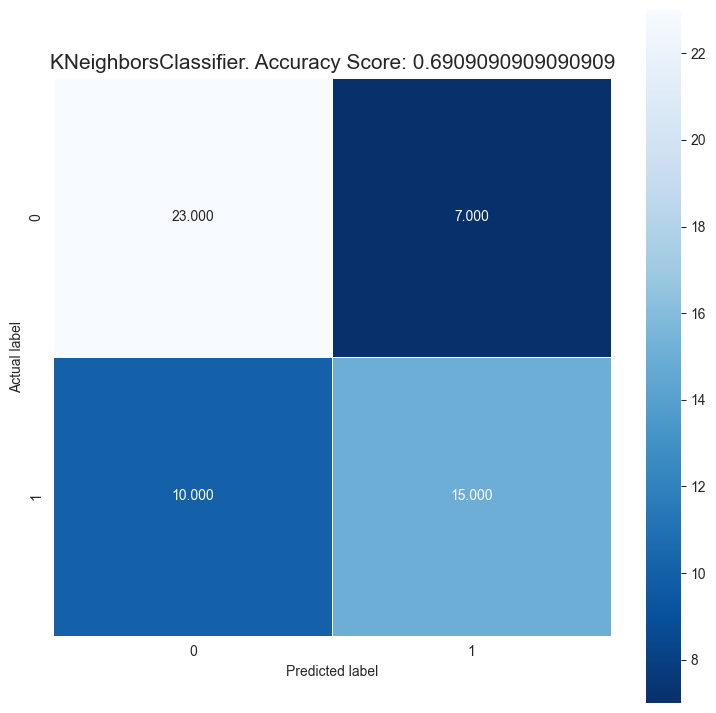

SVC
>acc=0.582, cfg={'kernel': 'rbf', 'C': 6.381945728643216}
Accuracy: 0.582 


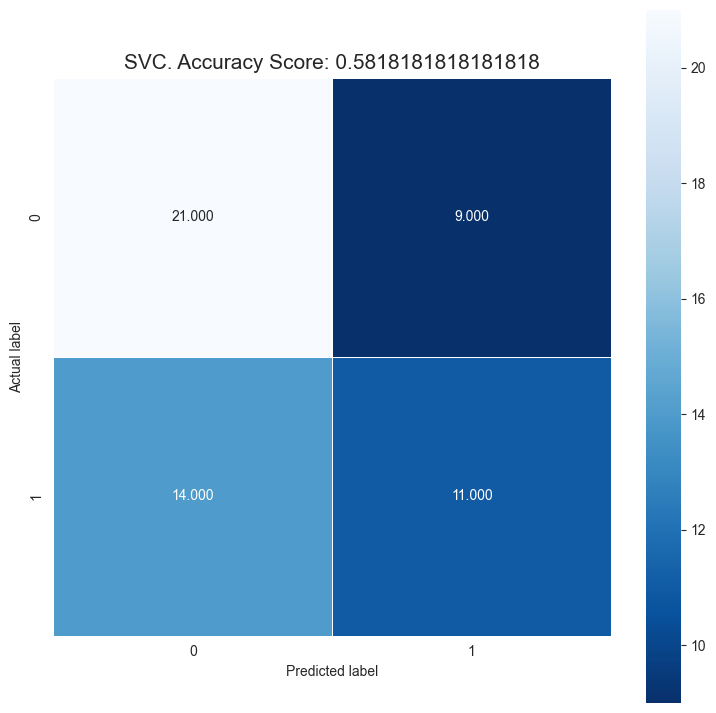

AdaBoostClassifier
>acc=0.655, cfg={'n_estimators': 15, 'learning_rate': 0.8948421052631579}
Accuracy: 0.655 


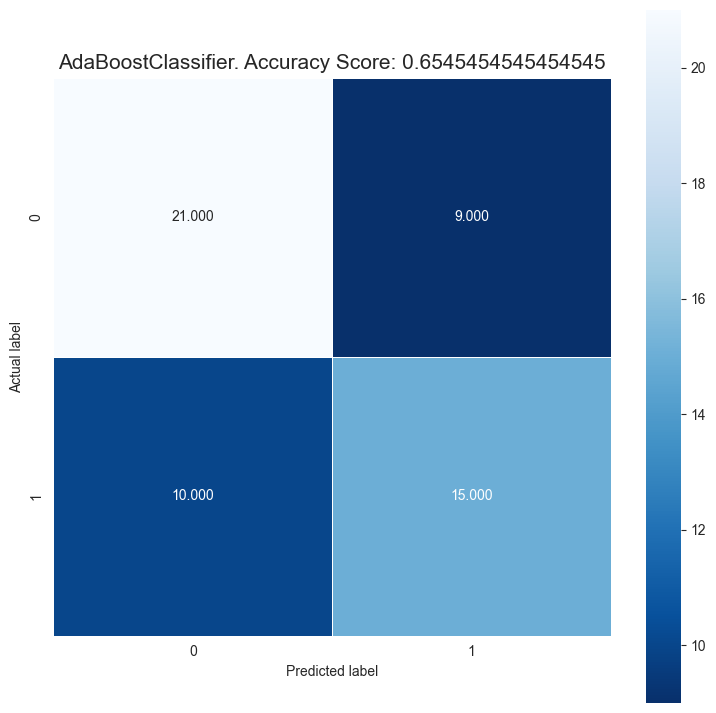

In [35]:
df_report_2 = pd.DataFrame()

df_report_2 = xval_test(reg_RF, space_rf, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_lin, space_lr, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_DT, space_dt, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_MLP, space_mlp, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_KN, space_kn, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_SVC, space_svc, df_report_2, concat_train, train_y, concat_test, test_y)
df_report_2 = xval_test(reg_adboost, space_adboost, df_report_2, concat_train, train_y, concat_test, test_y)

In [36]:
df_report_2

,Accuracy,F1,Precision,Recall,Balanced Acc,ROC-AUC,params
RandomForestClassifier,0.745455,0.730769,0.703704,0.76,0.746667,0.772667,"{'n_estimators': 5, 'max_features': 21, 'max_d..."
LogisticRegression,0.618182,0.588235,0.576923,0.60,0.616667,0.641333,"{'solver': 'lbfgs', 'max_iter': 54.27135678391..."
DecisionTreeClassifier,0.672727,0.625000,0.652174,0.60,0.666667,0.697333,"{'max_features': 'log2', 'max_depth': 13, 'cri..."
MLPClassifier,0.763636,0.648649,1.000000,0.48,0.740000,0.846667,"{'solver': 'adam', 'max_iter': 114, 'hidden_la..."
KNeighborsClassifier,0.690909,0.638298,0.681818,0.60,0.683333,0.705333,"{'weights': 'distance', 'n_neighbors': 14, 'al..."
SVC,0.581818,0.488889,0.550000,0.44,0.570000,0.705333,"{'kernel': 'rbf', 'C': 6.381945728643216}"
AdaBoostClassifier,0.654545,0.612245,0.625000,0.60,0.650000,0.604667,"{'n_estimators': 15, 'learning_rate': 0.894842..."
